In [1]:
import gzip
import gc
import math
import json
from collections import Counter, defaultdict
import random
from tqdm.notebook import tqdm
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def jl_to_list(fname):
    output = []
    with gzip.open(fname, "rb") as f:
        for line in f:
            output.append(json.loads(line))
    return output

### Load user data

In [2]:
samples = None
test_size = .2
rows = jl_to_list("data/train_dataset.jl.gz")
if samples:
    rows = rows[:samples]

### Train - test split

In [3]:
val_size = .15
rows_train, rows_test = train_test_split(rows, test_size = test_size, random_state = 42)
print(f"Train data: {len(rows_train)}.")
print(f"Test data: {len(rows_test)}.")

Train data: 330530.
Test data: 82633.


### Load items

In [4]:
item_data = jl_to_list("data/item_data.jl.gz")
metadata = {x["item_id"] : x for x in item_data}
all_items = list(metadata.keys())

### Map each item to an integer id

In [5]:
item_dict = {}
for i, item in enumerate(item_data):
    item_dict[item["item_id"]] = i

### Load item array

In [6]:
item_arr = np.load("items.npy")

In [7]:
item_dim = item_arr.shape[1]

### Candidate generator (workshop)

In [8]:
sales_x_domain = defaultdict(lambda: defaultdict(int))

for row in tqdm(rows_train):
    #viewed = [ev['event_info'] for ev in row['user_history'] if ev['event_type']=='view']
    items = [row['item_bought']]
    for item in items:
        domain = metadata[item]['domain_id']
        sales_x_domain[domain][item]+=1

In [9]:
def domains_visited(row, max_views=15):
    """
    For a given user story (row), returns a Counter 
    of the domains visited by the user.
    """
    
    domains = Counter()
    
    viewed = [ev['event_info'] for ev in row['user_history'] 
              if ev['event_type']=='view']
    
    if len(viewed) > max_views:
        viewed = viewed[:15]
        
    for item in viewed:
        domain = metadata[item]['domain_id']
        domains[domain] += 1
        
    return domains

In [10]:
def top_items(domain,k=10):
    """
    Given the sales_x_domain info and a certain domain, 
    returns the top k selling items in that domain.
    """
    
    top = sales_x_domain[domain]
    top = Counter(top)
    top = top.most_common(k)
    
    return [x[0] for x in top]

In [11]:
def top_by_best_domain(row, k=10):
    """
    For a given user story (row) it returns the top k selling
    items of the most visited domain.
    """
    
    views = [ev['event_info'] for ev in row['user_history'] if ev['event_type']=='view']
    if len(views) == 0:
        return []
    domain = domains_visited(row)    
    domain = domain.most_common(1)[0][0]
    return top_items(domain, k=k)

### Get candidates (function)

In [12]:
def get_candidates(row, num = 100, train = False):
    candidates = []
    if train:
        candidates += [row["item_bought"]]
    views = [ev['event_info'] for ev in row['user_history'] if ev['event_type']=='view']
    if len(views) == 0:
        return candidates + random.choices(all_items, k = num - len(candidates))
    
    candidates += views
    candidates = candidates[:num]
    if len(candidates) < num:
        candidates += top_by_best_domain(row, k = num - len(candidates))
    
    candidates = list(set(candidates))            # candidates repetidos?
    if len(candidates) < num:
        candidates += random.choices(all_items, k = num - len(candidates))
    
    return candidates

In [13]:
ks = [10, 20]
n_succs = []
for k in tqdm(ks):
    n_succ = 0
    for r in rows_train:
        candidates = get_candidates(r, num = k, train = True)
        if r["item_bought"] in candidates: n_succ += 1
            
    n_succs.append(n_succ)

plt.figure(figsize = (12.5, 7.5))
plt.grid("both")
for i, k in enumerate(ks):
    plt.scatter(k, n_succs[i]/len(rows_train))

KeyboardInterrupt: 

### Generate y matrix

In [14]:
k = 50
train = True
y_train = np.zeros((len(rows_train), k))
cands_train = np.zeros((len(rows_train), k), dtype = np.int)
for i, r in enumerate(tqdm(rows_train)):
    bought_id = r["item_bought"]
    cands_train[i, :] = get_candidates(r, k, train = True)
    for j, c in enumerate(cands_train[i]):
        if c == bought_id:
            y_train[i, j] = 1
        #elif metadata[c]["domain_id"] == metadata[bought_id]["domain_id"]:
            #y_train[i, j] = 0 #.5?

In [25]:
n_fail = 0
for y in tqdm(y_train):
    c = np.count_nonzero(y)
    if c > 1: n_fail += 1
        
print(c)


1


In [37]:
k = 50
train = False
y_test = np.zeros((len(rows_test), k))
cands_test = np.zeros((len(rows_test), k), dtype = np.int)
for i, r in enumerate(tqdm(rows_test)):
    bought_id = r["item_bought"]
    cands_test[i, :] = get_candidates(r, k, train = train)
    for j, c in enumerate(cands_test[i]):
        if c == bought_id:
            y_test[i, j] = 1
        #elif metadata[c]["domain_id"] == metadata[bought_id]["domain_id"]:
            #y_test[i, j] = 0 #.5?

In [27]:
n_fail = 0
fails = []
for i, y in enumerate(tqdm(y_test)):
    c = np.count_nonzero(y)
    if c > 1: 
        n_fail += 1
        fails.append(i)
        
print(n_fail)


1


### Calculate maximum performance after candidate generator

In [45]:
def best_ndcg(y):
    y_sort = sorted(y.tolist(), reverse = True)
    y_sort = y_sort[:10]
    buf = 0
    for i, ys in enumerate(y_sort):
        den = 1/np.log(2+i)
        rel = 0
        if ys == .5:
            rel = 1
        if ys == 1:
            rel = 12
            
        buf += rel/den
    return buf/25.126926832033277

In [18]:
best_ndcg(np.array([0.5]*9 + [0]))

0.6011245495338303

In [46]:
s = 0
for y in tqdm(y_train):
    s += best_ndcg(y)

print(s/len(y_train))


0.11766071314154836


### Load word vectors

In [16]:
import csv
# open vector file
tsv_file = open("word2vec/vectors_q.tsv")
read_tsv = csv.reader(tsv_file, delimiter="\t")

vectors_wrd = []
for row in read_tsv:
    vectors_wrd.append(row)
tsv_file.close()

v_wrd = np.zeros((len(vectors_wrd), 32), dtype = np.float64)
for i, v in tqdm(enumerate(vectors_wrd)):
    for j, vi in enumerate(v):
        v_wrd[i,j] = float(vi)

# open keys file
tsv_file = open("word2vec/meta_q.tsv")
read_tsv = csv.reader(tsv_file, delimiter="\t")

keys_wrd = []
for key in read_tsv:
    keys_wrd.append(key[0])
tsv_file.close()

assert len(keys_wrd) == v_wrd.shape[0]

In [17]:
words_dict = {k : v for k, v in zip(keys_wrd, v_wrd)}
wrd_counter = Counter()
for i, wrd in enumerate(words_dict.keys()):
    if i == 0: continue
    wrd_counter[wrd] = i
    
word_dim = words_dict["de"].size

### Get sessions function

In [18]:
mean_dom = np.mean(item_arr[:,0:32], axis = 0)
mean_cat = np.mean(item_arr[:,32:64], axis = 0)

In [19]:
def query_2_sess(row):
    n_words = 4
    queries = [ev['event_info'] for ev in row['user_history'] if ev['event_type']=='search']
    arr = np.zeros((len(queries), item_dim))
    for i, q in enumerate(queries): 
        words = list(q.lower().split())
        ranks = []
        for w in words:
            ranks.append(wrd_counter[w])
        top = np.argsort(ranks)[::-1][:n_words]
        words_sort = [words[t] for t in top]
        if len(words_sort) < n_words: words_sort += ["[UNK]"]*(n_words - len(words_sort))
        word_vector = np.zeros((item_dim))
        word_vector[:32] = mean_dom
        word_vector[32:64] = mean_cat
        for j, w in enumerate(words_sort):
            try:
                word_vector[64 + j*word_dim : 64 + (1+j)*word_dim] = words_dict[w]
            except KeyError:
                word_vector[j*word_dim : (1+j)*word_dim] =  words_dict['[UNK]']
                
        arr[i,:] = word_vector
        
    return arr

In [20]:
def get_session(row, max_length = 15):
    views = [ev['event_info'] for ev in row['user_history'] if ev['event_type']=='view']
    views = views[-max_length:]
    if len(views) == 0:
        s_arr = query_2_sess(row)
    else:
        s_arr = np.zeros((len(views), item_arr.shape[1]))
        for i, v in enumerate(views):
            int_id = item_dict[v]
            s_arr[i] = item_arr[int_id]
    
    mt = s_arr[-1, :]
    ms = np.mean(s_arr, axis = 0)
    
    return mt, ms

In [21]:
mt_train = np.zeros((len(rows_train), item_arr.shape[1]))
ms_train = mt_train.copy()

mt_test = np.zeros((len(rows_test), item_arr.shape[1]))
ms_test = mt_test.copy()

for i, row in enumerate(tqdm(rows_train)):
    mt, ms = get_session(row, max_length = 15)
    mt_train[i, :] = mt
    ms_train[i, :] = ms

for i, row in enumerate(tqdm(rows_test)):
    mt, ms = get_session(row, max_length = 15)
    mt_test[i, :] = mt
    ms_test[i, :] = ms

### Vectorize candidates

#### Train

In [22]:
cands_arr_train = np.zeros((len(rows_train), k, item_dim))
for i, cands_int in enumerate(tqdm(cands_train)):
    V = np.zeros((cands_int.size, item_dim))
    for j, c in enumerate(cands_int):
        int_id = item_dict[c]
        V[j] = item_arr[int_id]
    cands_arr_train[i] = V

#### Test

In [38]:
cands_arr_test = np.zeros((len(rows_test), k, item_dim))
for i, cands_int in enumerate(tqdm(cands_test)):
    V = np.zeros((cands_int.size, item_dim))
    for j, c in enumerate(cands_int):
        int_id = item_dict[c]
        V[j] = item_arr[int_id]
    cands_arr_test[i] = V

In [24]:
#del item_arr
#del metadata
#del rows

### Lets begin training (sigh)

In [24]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Permute
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dot
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

### Third try

In [25]:
rate = .2
hidden_dim = 128

# inputs
input_mt = Input(shape = (item_dim,))
input_ms = Input(shape = (item_dim,))
input_xi = Input(shape = (k, item_dim,))

# transform item dim
trans = Dense(hidden_dim, activation = "tanh")
input_mt_T = trans(input_mt)
input_ms_T = trans(input_ms)
input_xi_T = trans(input_xi)

# mlps
hs = Dense(hidden_dim, activation = "tanh", name = "MLP_A")(input_ms_T)
#hs = Dropout(rate = rate)(hs)
hs = Reshape((1, hidden_dim))(hs)

ht = Dense(hidden_dim, activation = "tanh", name = "MLP_B")(input_mt_T)
#ht = Dropout(rate = rate)(ht)
ht = Reshape((1, hidden_dim))(ht)

# conc for products
ht_conc = Concatenate(axis = 1)([ht]*k)    # batch dimension = 0!!
#hs_conc = Concatenate(axis = 1)([hs]*k)

# hadamard
hadamard = Multiply()([ht_conc, input_xi_T])

# transpose hadamard for dot
had_T = Permute(dims = (2,1))(hadamard)

# dot
dot = Dot(axes = (2,1), name = "DOT")([hs, had_T])

# softmax?
smax = Activation("softmax")(dot)

# output
output = Reshape((k,))(smax)

In [26]:
# compile model    
model = Model(inputs=[input_mt, input_ms, input_xi], outputs=output)
#model.summary()
# optimizer
opt = Adam(lr=1e-3, decay=2e-3 / 200)
# loss
loss = tf.keras.losses.categorical_crossentropy #mse
# compile
model.compile(loss=loss, 
              optimizer=opt,
              metrics=[keras.metrics.categorical_accuracy])

In [27]:
model.output.shape

TensorShape([None, 100])

### Train the model

In [44]:
epochs = 50
bs = 24
model.fit(
    x=[mt_train, ms_train, cands_arr_train], y=y_train,
    validation_data=([mt_test, ms_test, cands_arr_test], y_test),
    epochs=epochs, batch_size=bs)

Epoch 1/50
13773/13773 [==============================] - 91s 7ms/step - loss: 2.5169 - categorical_accuracy: 0.3350 - val_loss: 1.0096 - val_categorical_accuracy: 0.1094
Epoch 2/50
13773/13773 [==============================] - 83s 6ms/step - loss: 2.5144 - categorical_accuracy: 0.3358 - val_loss: 1.0031 - val_categorical_accuracy: 0.1116
Epoch 3/50
13773/13773 [==============================] - 84s 6ms/step - loss: 2.5125 - categorical_accuracy: 0.3363 - val_loss: 1.0107 - val_categorical_accuracy: 0.1095
Epoch 4/50
13773/13773 [==============================] - 85s 6ms/step - loss: 2.5108 - categorical_accuracy: 0.3366 - val_loss: 1.0082 - val_categorical_accuracy: 0.1099
Epoch 5/50
13773/13773 [==============================] - 84s 6ms/step - loss: 2.5087 - categorical_accuracy: 0.3371 - val_loss: 1.0079 - val_categorical_accuracy: 0.1108
Epoch 6/50
13773/13773 [==============================] - 84s 6ms/step - loss: 2.5066 - categorical_accuracy: 0.3376 - val_loss: 1.0126 - val_cat

KeyboardInterrupt: 












### Save model

In [43]:
model.save("stmp_v1")

INFO:tensorflow:Assets written to: stmp_v1/assets


### Get predictions (train)

In [29]:
preds = model.predict([mt_train, ms_train, cands_arr_train], batch_size = 16)

### Test

In [45]:
preds = model.predict([mt_test, ms_test, cands_arr_test], batch_size = 16)

In [46]:
def get_pk(mt, ms, cands_arr, preds, y, k = 10):

    preds_sort = np.argsort(preds, axis = 1)[:, ::-1]
    preds_sort = preds_sort[:, :k]
    N = 0
    hits = 0
    for y, p in zip(y, preds_sort):
        true = np.where(y == 1)[0][0]
        if true.size != 0:
            N += 1
            if int(true) in p:
                hits += 1
                
    return hits/N

In [80]:
ks = np.arange(20)
pks = []
for k in tqdm(ks):
    pk = get_pk(mt_train, ms_train, cands_arr_train, preds, y_train, k = k)
    pks.append(pk)

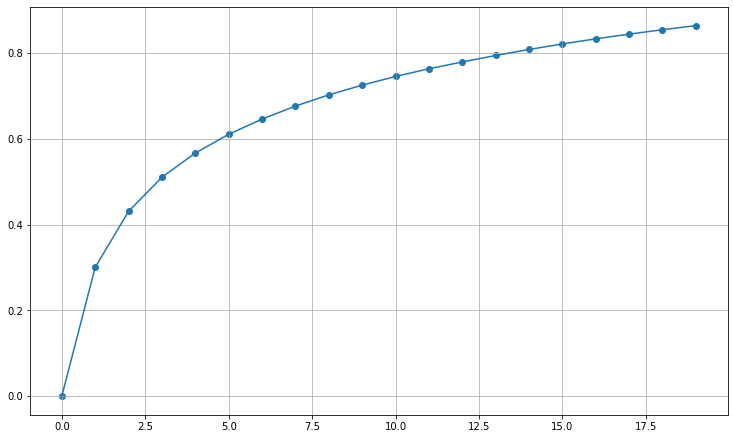

In [81]:
plt.figure(figsize = (12.5, 7.5))
plt.plot(ks, pks)
plt.scatter(ks, pks)
plt.grid("both")

In [47]:
y_preds = []
preds_sort = np.argsort(preds, axis = 1)[:, ::-1]
preds_sort = preds_sort[:, :10]
for i, p in enumerate(tqdm(preds_sort)):
    y_pred = [cands_test[i,j] for j in p]
    y_preds.append(y_pred)

In [48]:
y_true = [row['item_bought'] for row in rows_test]

In [49]:
from challenge_metric import ndcg_score
score = ndcg_score(y_true, y_preds, item_data, n_predictions = 10)
print(f'Your score is: {score}')

Your score is: 0.19570302906860243


In [50]:
top_by_best_domain(rows_train[0])

[1158631,
 2070608,
 1979875,
 68034,
 2070069,
 8726,
 1850013,
 1075129,
 1382798,
 737699]

In [51]:
y_pred[0]

256758

In [58]:
d = Dense(4)

In [59]:
N = 4
h = 3
w = 5
a = np.zeros((N, h, w))

In [61]:
d(a)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(4, 3, 4), dtype=float32, numpy=
array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]], dtype=float32)>